<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_process_circle.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px;" />

# Apply Operator with Pangeo

The apply operator employ a process on the datacube that calculates new pixel values for each pixel, based on n other pixels.

Let's start again with the same sample data from the Sentinel-2 STAC Collection, applying the filters directly in the `stackstac.stack` call, to reduce the amount of data.

In [1]:
# STAC Catalogue Libraries
import pystac_client
import stackstac

In [2]:
#                  West,     South,     East,      North
spatial_extent = [11.259613, 46.461019, 11.406212, 46.522237]
temporal_extent = ['2022-07-10T00:00:00Z','2022-07-13T00:00:00Z']
bands = ["red","green","blue"]

In [3]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)
s2_items = catalog.search(
    bbox=spatial_extent,
    datetime=temporal_extent,
    query=["eo:cloud_cover<50"],
    collections=["sentinel-2-l2a"]
).item_collection()

s2_cube = stackstac.stack(s2_items,
                     bounds_latlon=spatial_extent,
                     assets=bands
)
s2_cube

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-0747b87a1b91037120a189227e8f5908' (time: 1,
                                                                band: 3,
                                                                y: 714, x: 1146)>
dask.array<fetch_raster_window, shape=(1, 3, 714, 1146), dtype=float64, chunksize=(1, 1, 714, 1024), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 2022-07-12...
    id                                       (time) <U24 'S2B_32TPS_20220712_...
  * band                                     (band) <U5 'red' 'green' 'blue'
  * x                                        (x) float64 6.733e+05 ... 6.848e+05
  * y                                        (y) float64 5.155e+06 ... 5.148e+06
    view:sun_azimuth                         float64 146.9
    ...                                       ...
    proj:shape                               object {10980}
    gsd                                      int64 10
    common_name                              (band) <U5 'red' 'green' 'blue'
    center_wavelength                        (band) float64 0.665 0.56 0.49
    full_width_half_max                      (band) float64 0.038 0.045 0.098
    epsg                                     int64 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(673310.0, 5147750.0, 684770.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 673310.00|\n| 0.00,-10.00, 5154890.00|\n| 0.0...
    resolution:  10.0

Visualize the RGB bands of our sample dataset:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


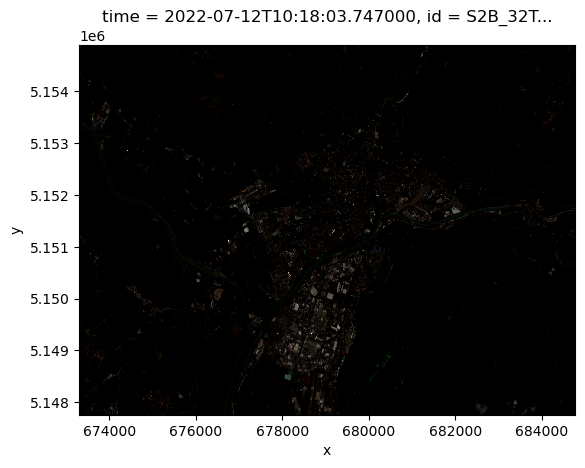

In [4]:
s2_cube.isel(time=0).plot.imshow()

### Apply an arithmetic formula

We would like to improve the previous visualization, rescaling all the pixels between 0 and 1.

We can use `apply` in combination with other `math` processes.

In [5]:
s2_cube

<xarray.DataArray 'stackstac-0747b87a1b91037120a189227e8f5908' (time: 1,
                                                                band: 3,
                                                                y: 714, x: 1146)>
dask.array<fetch_raster_window, shape=(1, 3, 714, 1146), dtype=float64, chunksize=(1, 1, 714, 1024), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 2022-07-12...
    id                                       (time) <U24 'S2B_32TPS_20220712_...
  * band                                     (band) <U5 'red' 'green' 'blue'
  * x                                        (x) float64 6.733e+05 ... 6.848e+05
  * y                                        (y) float64 5.155e+06 ... 5.148e+06
    view:sun_azimuth                         float64 146.9
    ...                                       ...
    proj:shape                               object {10980}
    gsd                                      int64 10
    common_name                              (band) <U5 'red' 'green' 'blue'
    center_wavelength                        (band) float64 0.665 0.56 0.49
    full_width_half_max                      (band) float64 0.038 0.045 0.098
    epsg                                     int64 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(673310.0, 5147750.0, 684770.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 673310.00|\n| 0.00,-10.00, 5154890.00|\n| 0.0...
    resolution:  10.0

In [6]:
import xarray as xr
input_min = -0.1
input_max = 0.2
output_min = 0
output_max = 1

def rescale(x, input_min, input_max, output_min, output_max):
    y = xr.where(x>=input_min, x, input_min)
    y = xr.where(y<=input_max, y, input_max)
    return ((y - input_min) / (input_max - input_min)) * (output_max - output_min) + output_min

scaled_data = rescale(s2_cube, input_min, input_max, output_min, output_max)

In [7]:
input_min = -0.1
input_max = 0.2
output_min = 0
output_max = 1

def rescale(x, input_min, input_max, output_min, output_max):
    return ((x.where(x>=input_min, input_min).where(x<=input_max, input_max) - input_min) / (input_max - input_min)) * (output_max - output_min) + output_min

scaled_data = rescale(s2_cube, input_min, input_max, output_min, output_max)

In [8]:
scaled_data.load()

<xarray.DataArray 'stackstac-0747b87a1b91037120a189227e8f5908' (time: 1,
                                                                band: 3,
                                                                y: 714, x: 1146)>
array([[[[0.218     , 0.20266667, 0.20733333, ..., 0.138     ,
          0.095     , 0.11733333],
         [0.252     , 0.24733333, 0.21933333, ..., 0.08866667,
          0.07866667, 0.07566667],
         [0.206     , 0.16066667, 0.19733333, ..., 0.07      ,
          0.08      , 0.08066667],
         ...,
         [0.23933333, 0.29166667, 0.12533333, ..., 0.072     ,
          0.07833333, 0.072     ],
         [0.196     , 0.30666667, 0.16666667, ..., 0.07733333,
          0.069     , 0.05133333],
         [0.178     , 0.28933333, 0.22066667, ..., 0.06766667,
          0.05966667, 0.058     ]],

        [[0.21566667, 0.19466667, 0.21133333, ..., 0.152     ,
          0.14466667, 0.15633333],
         [0.226     , 0.21133333, 0.23      , ..., 0.13233333,
          0.137     , 0.12533333],
         [0.21466667, 0.17      , 0.184     , ..., 0.13266667,
          0.13966667, 0.121     ],
...
         [0.296     , 0.29533333, 0.15933333, ..., 0.146     ,
          0.16166667, 0.13133333],
         [0.24      , 0.326     , 0.19666667, ..., 0.15633333,
          0.14      , 0.117     ],
         [0.24133333, 0.33133333, 0.21666667, ..., 0.14866667,
          0.139     , 0.13066667]],

        [[0.162     , 0.13633333, 0.15033333, ..., 0.08933333,
          0.08566667, 0.08533333],
         [0.16166667, 0.171     , 0.18      , ..., 0.06366667,
          0.06866667, 0.07333333],
         [0.14033333, 0.117     , 0.14733333, ..., 0.076     ,
          0.08      , 0.074     ],
         ...,
         [0.19666667, 0.24166667, 0.10166667, ..., 0.073     ,
          0.08366667, 0.06866667],
         [0.12966667, 0.26733333, 0.11733333, ..., 0.07866667,
          0.08233333, 0.07333333],
         [0.2       , 0.21466667, 0.183     , ..., 0.08666667,
          0.07966667, 0.07533333]]]])
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 2022-07-12...
    id                                       (time) <U24 'S2B_32TPS_20220712_...
  * band                                     (band) <U5 'red' 'green' 'blue'
  * x                                        (x) float64 6.733e+05 ... 6.848e+05
  * y                                        (y) float64 5.155e+06 ... 5.148e+06
    view:sun_azimuth                         float64 146.9
    ...                                       ...
    proj:shape                               object {10980}
    gsd                                      int64 10
    common_name                              (band) <U5 'red' 'green' 'blue'
    center_wavelength                        (band) float64 0.665 0.56 0.49
    full_width_half_max                      (band) float64 0.038 0.045 0.098
    epsg                                     int64 32632

Visualize the result and see how `apply` scaled the data resulting in a more meaningful visualization:

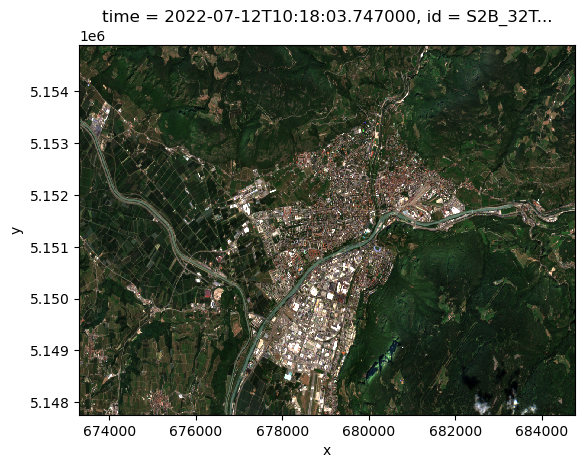

In [9]:
scaled_data.isel(time=0).plot.imshow()